# Imports

In [1]:
# Import necessary libraries for mathematical operations and plotting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle

# Import astropy modules for working with astronomical data
import astropy.units as u
from astropy.visualization import simple_norm, SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.coordinates import angular_separation, Angle, SkyCoord
from astropy.stats import sigma_clipped_stats
from astropy.io import fits
from astropy.nddata import Cutout2D
# Import os for directory operations
import os
# Import astroalign for aligning astronomical images
import astroalign as align
# Import twirl for peak finding and WCS (World Coordinate System) computations
from twirl import find_peaks
from twirl import gaia_radecs
from twirl.geometry import sparsify
from twirl import compute_wcs
# Import photutils for aperture photometry
from photutils.aperture import SkyCircularAperture
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture
from pylab import figure, cm
# Import pandas for data manipulation
import pandas as pd

import random

In [2]:
#Constnats
# BLUE_FILTER_COLOR =  'Blues'
# RED_FILTER_COLOR =  'Reds'

BLUE_FILTER_COLOR =  cm.grey
RED_FILTER_COLOR =  cm.grey

# Helper funcitons

In [3]:
def get_filename(directory):
    '''
    This gives all the filenames that are in a folder and returns them in list format
    '''
    filename_list=[]
    for filename in os.scandir(directory):
        if os.path.isfile(filename):
            filename_list.append(filename)
    return(filename_list)

def stack_frames(file_list):
    '''
    This takes a list of filenames
    Loads the data, averages all the images together
    Returns a master image
    '''
    imgs1=fits.open(file_list[0])
    data=imgs1[0].data

    height=len(data[:,0])
    width=len(data[0,:])
    
    master_img=np.zeros((height, width))
    count=0
    for file in file_list:
        count+=1
        imgs=fits.open(file)
        img_data=imgs[0].data
        master_img=master_img+img_data

    master_img=master_img/count

    return master_img

def correct_lights(light, dark, norm_flats_bias):
    '''
    light = list of light file names
    dark = master dark image
    norm_flats_bias = normalized bias subtracted flat images

    returns - list of image HDUs
    '''
    corr_HDU_list=[]
    for file in light:
        light_imgs=fits.open(file)
        light_data=light_imgs[0].data
        #light_header=light_imgs[0].header
        light_corr=(light_data-dark)/norm_flats_bias
        corr_HDU_list.append(light_corr)
    return corr_HDU_list

def align_image(list_of_images, reference_image):
    '''
    under costruction
    '''
    height=len(reference_image[:,0])
    width=len(reference_image[0,:])
    Master_image=np.zeros((height, width))
    count=0

    for image in list_of_images:
        count+=1
        aligned_image, footprint=align.register(image, reference_image)
        Master_image=Master_image+aligned_image

    Master_image=Master_image/count

    return Master_image

# Target

In [4]:
DIRECTORY="m2/"
# DIRECTORY="m13/"

# Gather all the files

In [5]:
#Get the file directory
darks_directory     = DIRECTORY + "darks/120/"
bias_directory      = DIRECTORY + "bias/2x2/"

flats1B_directory   = DIRECTORY + "Night 1/flats/B"
flats1R_directory   = DIRECTORY + "Night 1/flats/R"
flats2B_directory   = DIRECTORY + "Night 2/flats/B"
flats2R_directory   = DIRECTORY + "Night 2/flats/R"

light1B_directory   = DIRECTORY + "Night 1/B"
light1R_directory   = DIRECTORY + "Night 1/R"
light2B_directory   = DIRECTORY + "Night 2/B"
light2R_directory   = DIRECTORY + "Night 2/R"

#Create arays of file names, it's easier to reference them
darks_files         = get_filename(darks_directory)
bias_files          = get_filename(bias_directory)

flats1B_files       = get_filename(flats1B_directory)
flats1R_files       = get_filename(flats1R_directory)
flats2B_files       = get_filename(flats2B_directory)
flats2R_files       = get_filename(flats2R_directory)

light1B_files       = get_filename(light1B_directory)
light1R_files       = get_filename(light1R_directory)
light2B_files       = get_filename(light2B_directory)
light2R_files       = get_filename(light2R_directory)

print("Detected " + str(len(darks_directory)) + " dark images")
print("Detected " + str(len(bias_files)) + " bias images")
print("Detected " + str(len(flats1B_files)) + " Blue Filter images from Nov 2nd 2024")
print("Detected " + str(len(flats1R_files)) + " Red Filter images from Nov 2nd 2024")
print("Detected " + str(len(flats2B_files)) + " Blue Filter images from Nov 5th 2024")
print("Detected " + str(len(flats2R_files)) + " Red Filter images from Nov 5th 2024")

Detected 13 dark images
Detected 65 bias images
Detected 15 Blue Filter images from Nov 2nd 2024
Detected 15 Red Filter images from Nov 2nd 2024
Detected 15 Blue Filter images from Nov 5th 2024
Detected 15 Red Filter images from Nov 5th 2024


# Make master bias and darks

In [6]:
master_bias = stack_frames(bias_files) 
master_dark = stack_frames(darks_files)

# Make master flats

In [7]:
#stack flat images for each day & filter to creat 4 master flats
flat1B_img = stack_frames(flats1B_files)
flat1R_img = stack_frames(flats1R_files)
flat2B_img = stack_frames(flats2B_files)
flat2R_img = stack_frames(flats2R_files)

#Subtract the bias from the flats
flat1B_bias = flat1B_img - master_bias 
flat1R_bias = flat1R_img - master_bias
flat2B_bias = flat2B_img - master_bias
flat2R_bias = flat2R_img - master_bias

#Normalize by dividing by the maximum value of the array
master_flat_1B = flat1B_bias / np.max(flat1B_bias) 
master_flat_1R = flat1R_bias / np.max(flat1R_bias)
master_flat_2B = flat2B_bias / np.max(flat2B_bias)
master_flat_2R = flat2R_bias / np.max(flat2R_bias)


# Correct Lights

In [8]:
master_light_1B = correct_lights(light1B_files, master_dark, master_flat_1B)
master_light_1R = correct_lights(light1R_files, master_dark, master_flat_1R)
master_light_2B = correct_lights(light2B_files, master_dark, master_flat_2B)
master_light_2R = correct_lights(light2R_files, master_dark, master_flat_2R)

# Choose a reference image

In [ ]:
# # pick a random day
# random_number = random.randint(1,2)

# if (random_number == 1): 
#     # day 1 blue filter
#     random_file_index = random.randint(0,len(light1B_files)-1)
#     ref_img_for_b_filter = fits.open(light1B_files[random_file_index])

# else:
#     # day 2 blue filter
#     random_file_index = random.randint(0,len(light2B_files)-1)
#     ref_img_for_b_filter = fits.open(light2B_files[random_file_index])



# if (random_number == 1):
#     # day 1 red filyer
#     random_file_index = random.randint(0,len(light1R_files)-1)
#     ref_img_for_r_filter = fits.open(light1R_files[random_file_index])

# else:
#     # day 2 red filter
#     random_file_index = random.randint(0,len(light2R_files)-1)
#     ref_img_for_r_filter = fits.open(light2R_files[random_file_index])

# grab the first night
ref_img_for_b_filter = fits.open(light1B_files[0])
ref_img_for_r_filter = fits.open(light1R_files[0])

# Get the data off the reference image

In [10]:
#get the header and the actual image from the choosen reference image
ref_header_b_filter   = ref_img_for_b_filter[0].header # this header will be stamped on any fits I make
ref_header_r_filter   = ref_img_for_r_filter[0].header # this header will be stamped on any fits I make

ref_data_b_filter     = ref_img_for_b_filter[0].data   # this is be use for allighining light frames
ref_data_r_filter     = ref_img_for_r_filter[0].data   # this is be use for allighining light frames

# Alighn light frame from each filters

In [11]:
# make a list of all the B and R filter of the lights 
b_filter_lights = master_light_1B + master_light_2B
r_filter_lights = master_light_1R + master_light_2R

# alligh the lights using that random image we picked
master_Bfilter_light = align_image(b_filter_lights, ref_data_b_filter)
master_Rfilter_light = align_image(r_filter_lights, ref_data_r_filter)

# create the fits file to work with
b_filter_fits = fits.PrimaryHDU(master_Bfilter_light, ref_header_b_filter)
r_filter_fits = fits.PrimaryHDU(master_Rfilter_light, ref_header_r_filter)

# Let's take a look at what we have so far

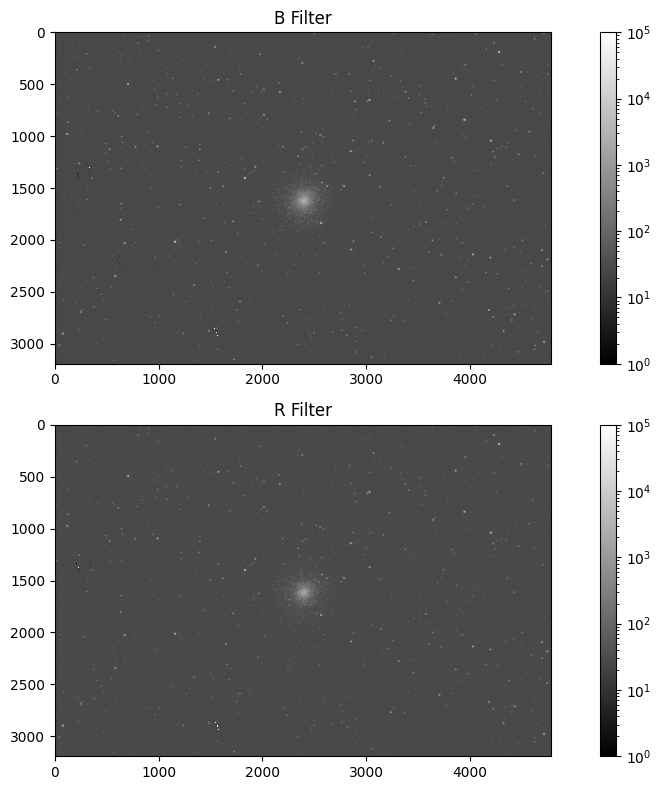

<Figure size 640x480 with 0 Axes>

In [12]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the B filter image in the first subplot
ax1.imshow(b_filter_fits.data, cmap = BLUE_FILTER_COLOR, norm = LogNorm(vmin = 1, vmax = 100000))
ax1.set_title('B Filter')

# Plot the R filter image in the second subplot
ax2.imshow(r_filter_fits.data, cmap = RED_FILTER_COLOR, norm = LogNorm(vmin = 1, vmax = 100000))
ax2.set_title('R Filter')

# Add colorbars to both subplots
fig.colorbar(ax1.imshow(b_filter_fits.data, cmap = BLUE_FILTER_COLOR, norm = LogNorm( vmin = 1, vmax = 100000 )), ax = ax1)
fig.colorbar(ax2.imshow(r_filter_fits.data, cmap = RED_FILTER_COLOR, norm = LogNorm( vmin = 1, vmax = 100000 )), ax = ax2)

# Adjust the layout to prevent overlap
plt.tight_layout()

# Save the figure to the drive
output_filepath = DIRECTORY + "B & R filter lights.jpg"
plt.savefig(output_filepath, format='jpg')

# Display the plot
plt.show()
plt.clf()

# Use twirl to find peaks

In [13]:
peak_location_b_filter = find_peaks(b_filter_fits.data)[0:20]
peak_location_r_filter = find_peaks(r_filter_fits.data)[0:20]


# display the peaks

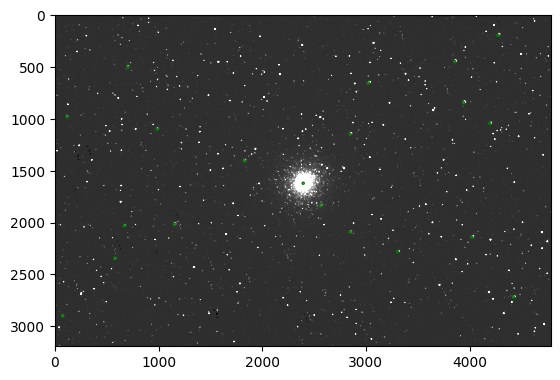

In [14]:

plt.imshow(b_filter_fits.data, vmin = 0.1 * np.median(b_filter_fits.data), vmax = 5 * np.median(b_filter_fits.data), cmap = BLUE_FILTER_COLOR)
_ = CircularAperture(peak_location_b_filter, r = 10.0).plot(color="g")

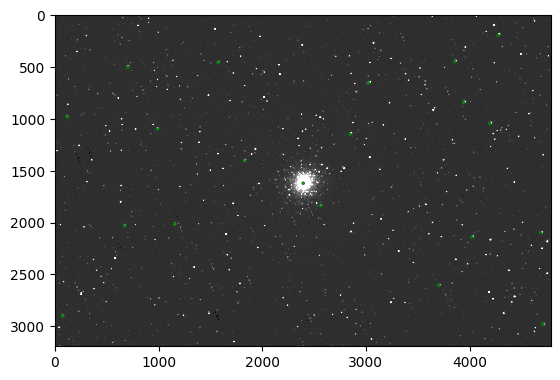

In [15]:
plt.imshow(r_filter_fits.data, vmin = 0.1 * np.median(r_filter_fits.data), vmax = 5 * np.median(r_filter_fits.data), cmap = RED_FILTER_COLOR)
_ = CircularAperture(peak_location_r_filter, r = 10.0).plot(color="g")

# Obtain and filter RA/DEC coordinates from the Gaia catalog

In [16]:
all_radecs_b_filter = gaia_radecs((b_filter_fits.header['RA'], b_filter_fits.header['DEC']), 1.2 * 0.65)
all_radecs_r_filter = gaia_radecs((r_filter_fits.header['RA'], r_filter_fits.header['DEC']), 1.2 * 0.65)

# we only keep stars 0.01 degree apart from each other
thrushold           = 0.01 # degrees
all_radecs_b_filter = sparsify(all_radecs_b_filter, thrushold)
all_radecs_r_filter = sparsify(all_radecs_r_filter, thrushold)

# Map WCS coordinates to image coordinate

In [17]:
# we only keep the 30 brightest stars from gaia
wcs_b_filter = compute_wcs(peak_location_b_filter, all_radecs_b_filter[0:30], tolerance = 10)
wcs_r_filter = compute_wcs(peak_location_r_filter, all_radecs_r_filter[0:30], tolerance = 10)

# Plot the detected sources

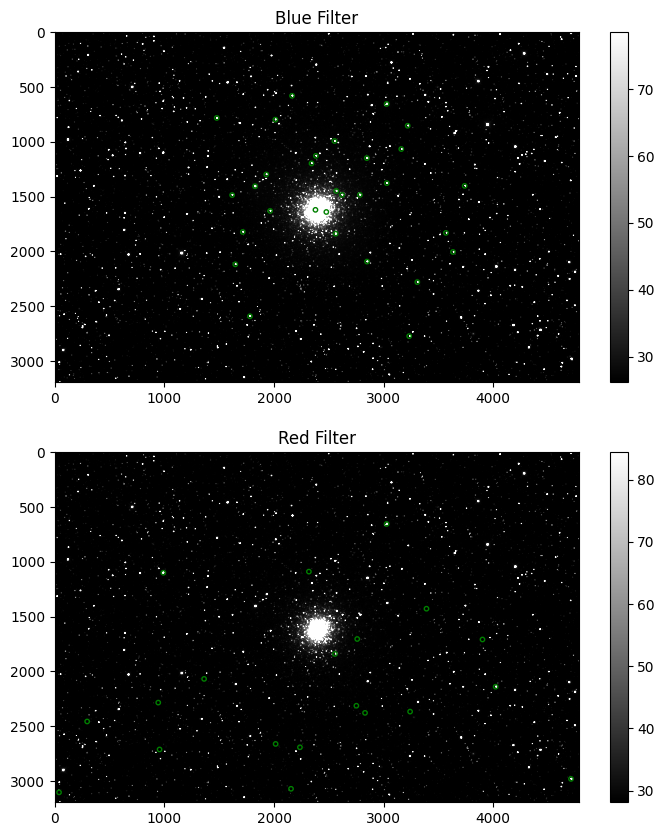

<Figure size 640x480 with 0 Axes>

In [18]:
# Plotting the combined graph
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Blue filter plot (top)
radecs_location_b_fiter = np.array(wcs_b_filter.world_to_pixel_values(all_radecs_b_filter))
im1 = ax1.imshow(b_filter_fits.data, vmin= np.median(b_filter_fits.data), vmax= 3 * np.median(b_filter_fits.data), cmap = BLUE_FILTER_COLOR)
CircularAperture(radecs_location_b_fiter[0:30], 20).plot(color = "g", ax = ax1)
ax1.set_title('Blue Filter')

# Red filter plot (bottom)
radecs_locations_r_filter = np.array(wcs_r_filter.world_to_pixel_values(all_radecs_r_filter))
im2 = ax2.imshow(r_filter_fits.data, vmin = np.median(r_filter_fits.data), vmax = 3 * np.median(r_filter_fits.data), cmap = RED_FILTER_COLOR)
CircularAperture(radecs_locations_r_filter[0:30], 20).plot(color = "g", ax = ax2)
ax2.set_title('Red Filter')

# Add colorbars
fig.colorbar(im1, ax = ax1, orientation = 'vertical', fraction = 0.046, pad = 0.04)
fig.colorbar(im2, ax = ax2, orientation = 'vertical', fraction = 0.046, pad = 0.04)

# Save the combined plot
plt.savefig(DIRECTORY + "Gaia Catalog Star.jpg")

plt.show()
plt.clf()


# Update Header for the lights with the new WCS

In [19]:
b_filter_fits.header.update(wcs_b_filter.to_header())
r_filter_fits.header.update(wcs_r_filter.to_header())

# Normalize the lights

In [20]:
b_filter_fits.data = b_filter_fits.data/(16*120.0)
r_filter_fits.data = r_filter_fits.data/(16*120.0)

# Save the Lights as FITS files

In [21]:
# locate the place you wanna save the fits files
output_directory_b_filter = DIRECTORY + "Light_B.fits"
output_directory_r_filter = DIRECTORY + "Light_R.fits"

# write the files to drive
b_filter_fits.writeto(output_directory_b_filter, overwrite = True)
r_filter_fits.writeto(output_directory_r_filter, overwrite = True)

# LAB 02

# Get the co-orditane of M2 stars and their brightness from Database
#### used CANFAR's Stetson Database

In [22]:
# load the data from memory
coords = pd.read_csv( DIRECTORY + "NGC7089.pos", sep='[ ]{2,}', engine='python') # replace anything w 2 or more spaces with just a space
mags = pd.read_csv(DIRECTORY + "NGC7089.pho", sep='[ ]{1,}', engine='python') # replace anything w 1 or more spaces with just a space



# Let's extract what we need from the stetson database

In [23]:
# add coloum names to the coordinate file
coords.rename(columns={'323.36209232807' : 'RA', '-00.84555554920' : 'DEC'}, inplace=True) # replace the orgonal col names for somethig meaningfull

# Convert the DEC column to string type first
coords['DEC'] = coords['DEC'].astype(str)

# Now you can use the .str accessor to replace spaces
coords['DEC'] = coords['DEC'].str.replace(" ", "")

# Convert the DEC column back to float type
coords['DEC'] = coords['DEC'].astype(float)

# Perform the merge with the photometry data
stetson = pd.merge(coords[["Reference", 'RA', 'DEC']], mags[["Reference", 'B', 'sigma.1', 'R', 'sigma.3']], how='inner', on=['Reference'])

# Filter the stars with magnitude of 18 or brighter
stetson = stetson[(stetson.B < 19) & (stetson.R < 19)]

stetson_b_filter = stetson[["Reference", 'RA', 'DEC', 'B', 'sigma.1']]
stetson_r_filter = stetson[["Reference", 'RA', 'DEC', 'R', 'sigma.3']]


# Lets plot what we extracted

In [24]:
stetson_pos_b_filter = np.array(wcs_b_filter.world_to_pixel_values( stetson_b_filter[["RA", "DEC"]] ))
stetson_pos_r_filter = np.array(wcs_r_filter.world_to_pixel_values( stetson_r_filter[["RA", "DEC"]] ))


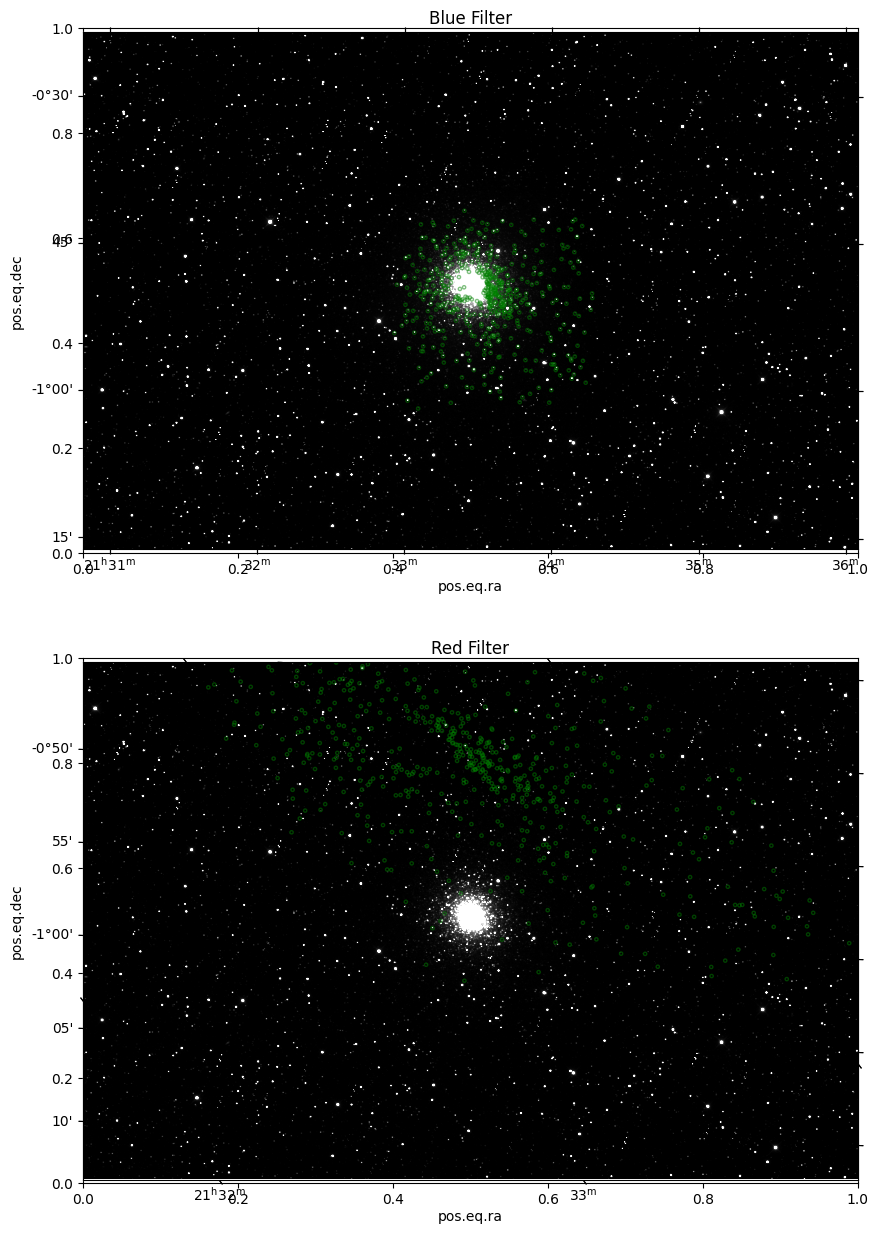

<Figure size 640x480 with 0 Axes>

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 15))

# Blue filter plot
ax1 = plt.subplot(2, 1, 1, projection = wcs_b_filter)
ax1.imshow(b_filter_fits.data, vmin = np.median(b_filter_fits.data), vmax = 3 * np.median(b_filter_fits.data), cmap = BLUE_FILTER_COLOR)
_ = CircularAperture(stetson_pos_b_filter, 10).plot(color = "g", alpha = 0.5)
ax1.set_title('Blue Filter')

# Blue filter plot
ax2 = plt.subplot(2, 1, 2, projection = wcs_r_filter)
ax2.imshow(r_filter_fits.data, vmin = np.median(r_filter_fits.data), vmax = 3 * np.median(r_filter_fits.data), cmap = RED_FILTER_COLOR)
_ = CircularAperture(stetson_pos_r_filter, 10).plot(color = "g", alpha = 0.5)
ax2.set_title('Red Filter')


plt.show()
plt.savefig(DIRECTORY + "Steton Catalog Stars.jpg")
plt.clf()

# Lets define & Work with a small subsection
#### FOV too large

In [26]:
position = (2200, 1000)
size = (1000, 1000)
cutout_b_filter = Cutout2D(b_filter_fits.data, position, size, wcs = wcs_b_filter)
cutout_r_filter = Cutout2D(r_filter_fits.data, position, size, wcs = wcs_r_filter)


In [27]:
#make 2 empyth fits files
b_filter_analysis = fits.PrimaryHDU()
r_filter_analysis = fits.PrimaryHDU()

#point them to the cutout data
b_filter_analysis.data = cutout_b_filter.data
r_filter_analysis.data = cutout_r_filter.data

b_filter_analysis.header.update(cutout_b_filter.wcs.to_header())
r_filter_analysis.header.update(cutout_r_filter.wcs.to_header())


In [28]:
#compute wcs for this cutout
peaks_b_filter = find_peaks(b_filter_analysis.data)[0:20]
wcs_cutout_b_filter = compute_wcs(peaks_b_filter, all_radecs_b_filter[0:30], tolerance = 10)
stetson_pos_b_filter = np.array(wcs_cutout_b_filter.world_to_pixel_values(stetson[["RA", "DEC"]]))


peaks_r_filter = find_peaks(r_filter_analysis.data)[0:20]
wcs_cutout_r_filter = compute_wcs(peaks_r_filter, all_radecs_r_filter[0:30], tolerance = 10)
stetson_pos_r_filter = np.array(wcs_cutout_r_filter.world_to_pixel_values(stetson[["RA", "DEC"]]))


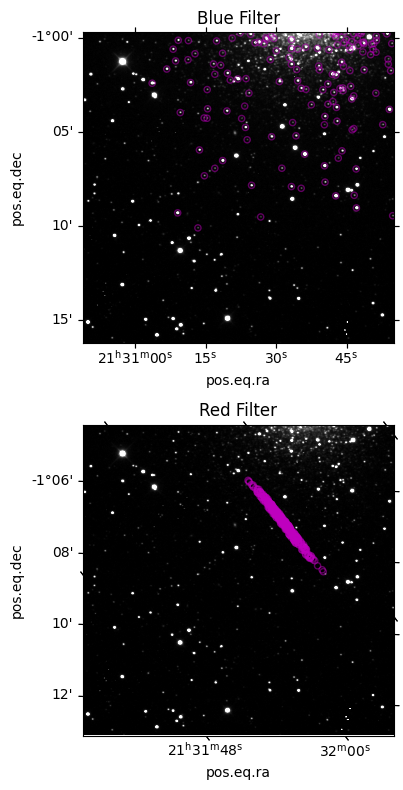

<Figure size 640x480 with 0 Axes>

In [29]:
# Create a new figure
fig = plt.figure(figsize=(10, 8))

# Blue filter plot on top
ax1 = fig.add_subplot(2, 1, 1, projection = wcs_b_filter)
ax1.imshow(b_filter_analysis.data, vmin=np.median(b_filter_fits.data), vmax=3 * np.median(b_filter_fits.data), cmap="Greys_r")
CircularAperture(stetson_pos_b_filter, 10).plot(ax=ax1, color="m", alpha=0.5)
ax1.set_title('Blue Filter')

# Red filter plot on bottom
ax2 = fig.add_subplot(2, 1, 2, projection = wcs_r_filter)
ax2.imshow(r_filter_analysis.data, vmin=np.median(r_filter_fits.data), vmax=3 * np.median(r_filter_fits.data), cmap="Greys_r")
CircularAperture(stetson_pos_r_filter, 10).plot(ax=ax2, color="m", alpha=0.5)
ax2.set_title('Red Filter')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
plt.savefig(DIRECTORY + "TWIRL peaks in curout.jpg")
